In [1]:
import tensorflow as tf
import os
import random
import numpy as np

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

import time

from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

In [2]:
print(tf.__version__)

2.4.0


In [3]:
# Initialise the input image dimensions and the number of colour channels
# X-ray images are greyscale so they we require only one colour channel
IMG_WIDTH = 1024
IMG_HEIGHT = 1024
IMG_CHANNELS = 1

In [4]:
# Initialise numpy arrays for X_data and Y_data to store the input images
X_data = np.zeros((180, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
Y_data = np.zeros((180, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

In [5]:
# Here the 180 images are loaded into numpy arrays with shape (180, 1024, 1024, 1)
# For each 1024 by 1024 matrix, each element in the matrix corresponds to the pixel value in the .tif image
# Load 1mm images into X_data
for i in range(10):
    img = imread(('1 mm/32p1r00' + str(i) + '.tif'), as_gray=True)[:,:]
    img = img[:,:,np.newaxis]
    X_data[i] = img
    
for i in range(10,100):
    img = imread(('1 mm/32p1r0' + str(i) + '.tif'), as_gray=True)[:,:]
    img = img[:,:,np.newaxis]
    X_data[i] = img
    
for i in range(10):
    img = imread(('1 mm/32p1r10' + str(i) + '.tif'), as_gray=True)[:,:]
    img = img[:,:,np.newaxis]
    X_data[100+i] = img
    
for i in range (10,80):
    img = imread(('1 mm/32p1r1' + str(i) + '.tif'), as_gray=True)[:,:]
    img = img[:,:,np.newaxis]
    X_data[100+i] = img
    
    
# Load 0mm data into Y_data
for i in range(10):
    img = imread(('0 mm/32p0r00' + str(i) + '.tif'), as_gray=True)[:,:]
    img = img[:,:,np.newaxis]
    Y_data[i] = img
    
for i in range(10,100):
    img = imread(('0 mm/32p0r0' + str(i) + '.tif'), as_gray=True)[:,:]
    img = img[:,:,np.newaxis]
    Y_data[i] = img
    
for i in range(10):
    img = imread(('0 mm/32p0r10' + str(i) + '.tif'), as_gray=True)[:,:]
    img = img[:,:,np.newaxis]
    Y_data[100+i] = img
    
for i in range (10,80):
    img = imread(('0 mm/32p0r1' + str(i) + '.tif'), as_gray=True)[:,:]
    img = img[:,:,np.newaxis]
    Y_data[100+i] = img

In [6]:
# Assign the first 170 images in X_data and Y_data to X_train and Y_train respectively 
# and the last 10 images to X_test and Y_test
TRAIN_NUM = 170
X_train = X_data[0:TRAIN_NUM]
X_test = X_data[TRAIN_NUM:]
Y_train = Y_data[0:TRAIN_NUM]
Y_test = Y_data[TRAIN_NUM:]

In [50]:
# Stretch X_train and Y_train and assign to X_train_stretch and Y_train_stretch respectively
X_train_temp = np.subtract(X_train,0.9)
X_train_stretch = np.multiply(X_train_temp,10)

Y_train_temp = np.subtract(Y_train,0.9)
Y_train_stretch = np.multiply(Y_train_temp,10)

X_test_temp = np.subtract(X_test,0.9)
X_test_stretch = np.multiply(X_test_temp,10)

In [51]:
print(np.amax(X_train))
print(np.amin(X_train))

1.0778287649154663
0.9167473316192627


In [52]:
print(np.amax(Y_train))
print(np.amin(Y_train))

1.0
0.9252259731292725


In [53]:
print(np.amax(X_train_stretch))
print(np.amin(X_train_stretch))

1.7782876491546629
0.16747331619262673


In [54]:
print(np.amax(Y_train_stretch))
print(np.amin(Y_train_stretch))

0.9999999999999998
0.2522597312927244


In [55]:
rand_train = random.randint(0, len(X_train)-1)

/home/andrew/anaconda3/envs/tensorflow/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
/home/andrew/anaconda3/envs/tensorflow/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


<function matplotlib.pyplot.show(close=None, block=None)>

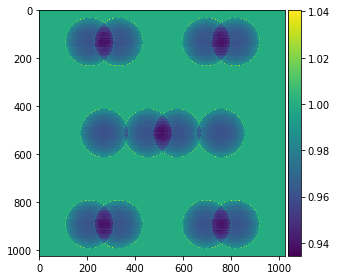

In [56]:
imshow(np.squeeze(X_train[rand_train]))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

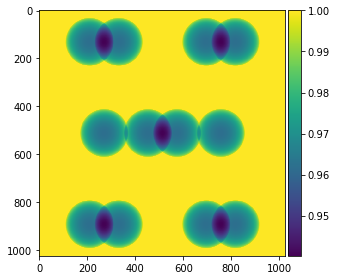

In [57]:
imshow(np.squeeze(Y_train[rand_train]))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

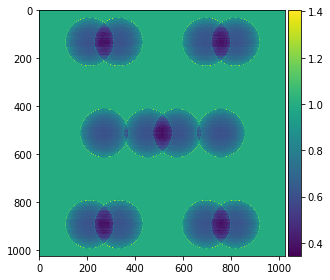

In [58]:
imshow(np.squeeze(X_train_stretch[rand_train]))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

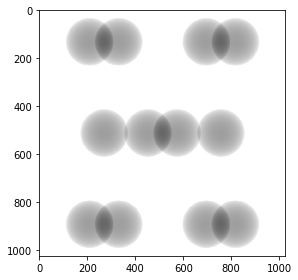

In [79]:
imshow(np.squeeze(Y_train_stretch[rand_train]))
plt.show

In [83]:
rand_test = random.randint(0, len(X_test)-1)

In [84]:
print(len(X_test))

10


/home/andrew/anaconda3/envs/tensorflow/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


<function matplotlib.pyplot.show(close=None, block=None)>

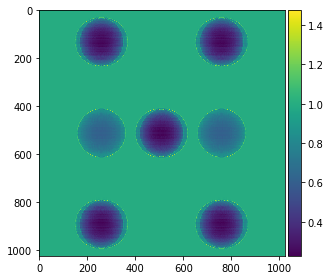

In [85]:
imshow(np.squeeze(X_test_stretch[rand_test]))
plt.show

In [62]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

#Expansive path
u4 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c3)
u4 = tf.keras.layers.concatenate([u4, c2])
c4 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

u5 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c4)
u5 = tf.keras.layers.concatenate([u5, c1], axis=3)
c5 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='relu')(c5)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(
    optimizer='sgd',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 1024, 1024, 1 160         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 1024, 1024, 1 0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 1024, 1024, 1 2320        dropout_5[0][0]                  
____________________________________________________________________________________________

In [63]:
NAME = "narrow-unet-relu-output-nostretch-25epochs-no-lambda-low-lr{}".format(int(time.time()))

In [64]:
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

In [65]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint(NAME, verbose=1, save_best_only=True)

callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
        tensorboard]

In [66]:
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

True

In [67]:
with tf.device("/device:GPU:0"):
    results = model.fit(X_train_stretch, Y_train_stretch, validation_split=0.1, batch_size=1, epochs=25, callbacks=callbacks)
model.save(os.path.join("models", NAME))

Epoch 1/25
153/153 [==============================] - 12s 77ms/step - loss: 0.0747 - root_mean_squared_error: 0.2625 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0627
Epoch 2/25
153/153 [==============================] - 11s 74ms/step - loss: 0.0176 - root_mean_squared_error: 0.1327 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0493
Epoch 3/25
153/153 [==============================] - 12s 75ms/step - loss: 0.0123 - root_mean_squared_error: 0.1109 - val_loss: 0.0020 - val_root_mean_squared_error: 0.0446
Epoch 4/25
153/153 [==============================] - 12s 76ms/step - loss: 0.0097 - root_mean_squared_error: 0.0986 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0421
Epoch 5/25
153/153 [==============================] - 12s 76ms/step - loss: 0.0082 - root_mean_squared_error: 0.0906 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0398
Epoch 6/25
153/153 [==============================] - 12s 76ms/step - loss: 0.0072 - root_mean_squared_error: 0.0847 - val_loss: 0

In [68]:
X_predict_stretch = model.predict(
    X_test_stretch, batch_size=None, verbose=1, steps=None, max_queue_size=10,
    workers=1, use_multiprocessing=False
)

1/1 [==============================] - 0s 288ms/step


/home/andrew/anaconda3/envs/tensorflow/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


<function matplotlib.pyplot.show(close=None, block=None)>

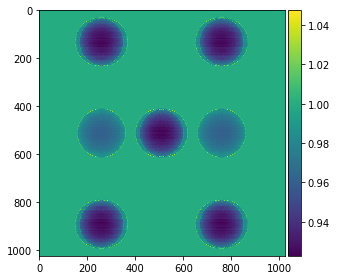

In [86]:
imshow(np.squeeze(X_test[rand_test]))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

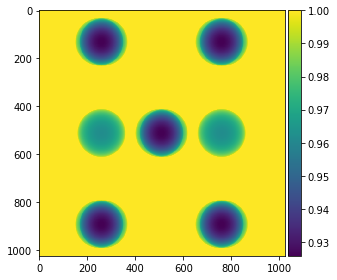

In [87]:
imshow(np.squeeze(Y_test[rand_test]))
plt.show

In [88]:
# Invert the stretch operation
X_predict_temp = np.divide(X_predict_stretch,10)
X_predict = np.add(X_predict_temp,0.9)

<function matplotlib.pyplot.show(close=None, block=None)>

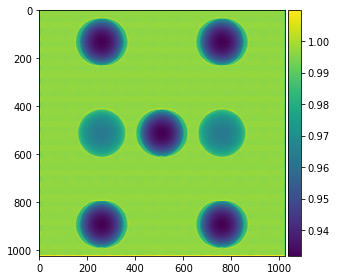

In [89]:
imshow(np.squeeze(X_predict[rand_test]))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

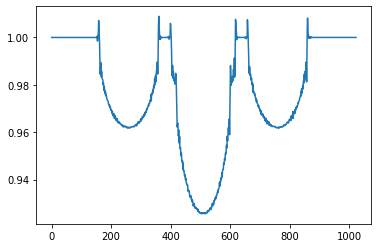

In [90]:
line = X_test[rand_test,512]
plt.plot(np.squeeze(line))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

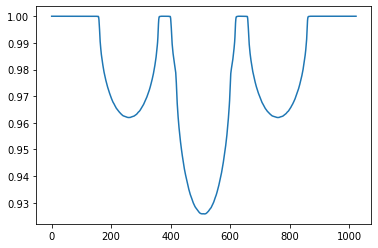

In [91]:
line = Y_test[rand_test,512]
plt.plot(np.squeeze(line))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

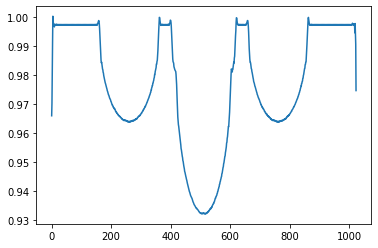

In [92]:
line = X_predict[rand_test,512]
line.shape
plt.plot(np.squeeze(line))
plt.show